# Introduction

In the class of machine learning approaches that are based on tree-like decision makers, many improved algorithms have been developed over the past two decades. We will go through three noteworthy designs that build on the idea of ensembles. The general idea is to train multiple models and combine them in various ways to improve performance.

There are two primary ways of doing this when it comes to decision trees. The first is to average the output of multiple trees which limits the variance of the output given the central limit theorem. The second way is to build trees in sequence and use the output of each one to reduce the bias in the next one.

# Bagging 

A Bagging model works by dividing a dataset, training one tree per subset, and averaging the results. There are variants of the Bagging approach with distinct names determined by how the data is divided (i.e. Pasting, Bagging, Random Subspaces, Random Patches, etc...).

Bagging is an ensemble algorithm, in that multiple models are combined to produce a net result that outperforms any of the individual models. This approach can significantly reduce the amount of variance in the prediction results.

Bagging was first developed in 1994 by Breiman et al1.



Imagine a scenario where multiple samples are collected from a data source. For any given sample, a statistic computed on those data will vary between the different samples. This variation follows what is termed a sampling distribution. 

The bootstrap method seeks to estimate this sampling distribution by continually resampling from the available data, with replacement. By “with replacement”, we mean that each data point in the available sample can be resampled multiple times. Typically this resampling is done until the selected data is of equal size to the original sample. This process can be repeated multiple times to yield a set of resampled, bootstrapped samples.

The bootstrap method can therefore be outlined in the following 4 points:

- Ensure each data point in the original sample has equal probability of being selected
- Select a data point from the original sample for inclusion in the current bootstrap sample. This selection is done with replacement
- Repeat point 2. until the current bootstrap sample is the same size as the original sample
- Repeat points 2. & 3. until the required number of bootstrap samples are obtained



In [64]:
## function to generate bootstrap datasets ##
def make_bootstraps(data,n_bootstraps=100):
    #initialize output dictionary & unique value count
    dc   = {}
    unip = 0
    #get sample size
    b_size = data.shape[0]
    #get list of row indexes
    idx = [i for i in range(b_size)]
    #loop through the required number of bootstraps
    for b in range(n_bootstraps):
        #obtain boostrap samples with replacement
        sidx   = np.random.choice(idx,replace=True,size=b_size)
        b_samp = data[sidx,:]
        #compute number of unique values contained in the bootstrap sample
        unip  += len(set(sidx))
        #obtain out-of-bag samples for the current b
        oidx   = list(set(idx) - set(sidx))
        o_samp = np.array([])
        if oidx:
            o_samp = data[oidx,:]
        #store results
        dc['boot_'+str(b)] = {'boot':b_samp,'test':o_samp}
    #state the mean number of unique values in the bootstraps
    print('Mean number of unique values in each bootstrap: {:.2f}'.format(unip/n_bootstraps))
    #return the bootstrap results
    return(dc)

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split

from sklearn.datasets import fetch_covtype

In [66]:
# covtype is a moderately complex "real world" dataset
# it might take a minute to download the dataset

covtype = fetch_covtype()

# Let's split it 
x, xt, y, yt = train_test_split(covtype.data, covtype.target, test_size = 0.20)

#print(covtype.DESCR)

In [68]:
bootstrap = make_bootstraps(x)

Mean number of unique values in each bootstrap: 293791.92


In [69]:
bootstrap

{'boot_0': {'boot': array([[2.950e+03, 3.580e+02, 1.600e+01, ..., 0.000e+00, 0.000e+00,
          0.000e+00],
         [3.130e+03, 1.080e+02, 2.600e+01, ..., 0.000e+00, 0.000e+00,
          0.000e+00],
         [3.076e+03, 4.100e+01, 1.400e+01, ..., 0.000e+00, 0.000e+00,
          0.000e+00],
         ...,
         [3.424e+03, 3.430e+02, 1.000e+01, ..., 1.000e+00, 0.000e+00,
          0.000e+00],
         [2.890e+03, 5.700e+01, 1.400e+01, ..., 0.000e+00, 0.000e+00,
          0.000e+00],
         [2.793e+03, 9.500e+01, 1.200e+01, ..., 0.000e+00, 0.000e+00,
          0.000e+00]]),
  'test': array([[3139.,   14.,    4., ...,    0.,    0.,    0.],
         [2922.,  343.,   15., ...,    0.,    0.,    0.],
         [3001.,  292.,    5., ...,    0.,    0.,    0.],
         ...,
         [3217.,   36.,    7., ...,    0.,    0.,    0.],
         [3037.,   13.,   21., ...,    0.,    0.,    0.],
         [2563.,  325.,   28., ...,    0.,    0.,    0.]])},
 'boot_1': {'boot': array([[3.172e+03, 2.

In [70]:
# now that datasets are bigger, training takes marginally longer
# we will intentionally restrict depth to make differences more apparent

m = DecisionTreeClassifier(max_depth=15)

m.fit(x, y)

ŷ = m.predict(xt)
accuracy_score(yt, ŷ)

0.8532395893393458

In [71]:
confusion_matrix(yt, ŷ)

array([[34678,  7331,     0,     0,    25,     3,   220],
       [ 4542, 51460,   184,     0,   152,   233,    29],
       [    6,   433,  6129,    47,     9,   607,     0],
       [    0,     2,   131,   366,     0,    15,     0],
       [   56,  1071,    25,     0,   813,     2,     0],
       [    6,   657,   630,    20,     1,  2140,     0],
       [  569,    48,     0,     0,     0,     0,  3563]])

Text(0.5, 1.0, 'Mean AUC 0.85')

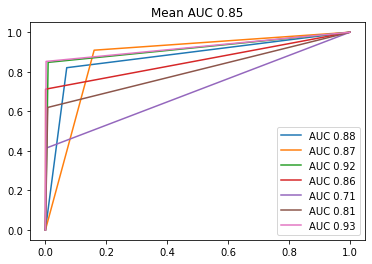

In [72]:
# compute ROC curves for each class and plot them

plt.close('all')

ytb = label_binarize(yt, classes=np.union1d(y, yt))
ŷb = label_binarize(ŷ, classes=np.union1d(y, yt))

fig, ax = plt.subplots()
area = []
for i in range(len(np.union1d(y, yt))):
    fpr, tpr, _ = roc_curve(ytb[:,i], ŷb[:,i])
    a = auc(fpr, tpr)
    area.append(a)
    plt.plot(fpr, tpr, label='AUC %0.2f' % a)

plt.legend(loc="lower right")
plt.title("Mean AUC %0.2f" % np.mean(area))

In [73]:
# we are training the same tree but using bagging
# set the number of estimators to the number of CPUs on your computer

mb = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15),
                       n_estimators=32,
                       verbose=1,
                       n_jobs=-1)

mb.fit(x, y)

ŷ = mb.predict(xt)
accuracy_score(yt, ŷ)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   28.0s remaining:  1.4min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   28.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.0s finished


0.8832043923134515

Text(0.5, 1.0, 'Mean AUC 0.87')

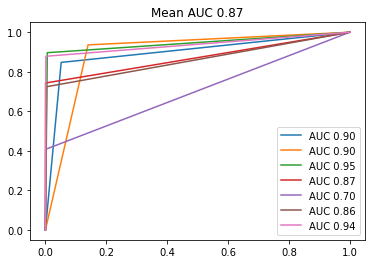

In [74]:
# compute ROC curves for each class and plot them

plt.close('all')

ytb = label_binarize(yt, classes=np.union1d(y, yt))
ŷb = label_binarize(ŷ, classes=np.union1d(y, yt))

fig, ax = plt.subplots()
area = []
for i in range(len(np.union1d(y, yt))):
    fpr, tpr, _ = roc_curve(ytb[:,i], ŷb[:,i])
    a = auc(fpr, tpr)
    area.append(a)
    plt.plot(fpr, tpr, label='AUC %0.2f' % a)

plt.legend(loc="lower right")
plt.title("Mean AUC %0.2f" % np.mean(area))

# Random Forest
In random forests each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set. Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset.

Random forest is a supervised machine learning algorithm used to solve classification as well as regression problems. It is a type of ensemble learning technique in which multiple decision trees are created from the training dataset and the majority output from them is considered as the final output.

Random forest is a very popular technique due to its simplicity and ability to produce robust results.

How Random Forest Works Random Forest works on the Bootstrap Aggregation (Bagging) technique of Ensemble learning –

Here, first of all, multiple training data is created by sampling data from the training set which is known as bootstrapping or bagging.

For example, if we have a data set (a,b,c,d,e,f,g,h,i,j) then the following training set can be obtained with bootstrap –

(a,f,d,j,h,c) (b,g,a,i,c,f) (i,d,c,e,a,d) (b,h,g,h,a,b)

You may notice here that the same data can appear multiple times across the training sets because we are doing random sampling with replacement.

- The leftover training data that has not been added in the bootstrapped data can be used to find the random forest accuracy. This is called the out-of-bag-datasets.

- Next, multiple decision trees are trained on each of these datasets. Instead of taking all features, we can add more variation by randomly selecting some features of the dataset for each of the decision trees.

- The output of each decision tree is aggregated to produce the final output. For classification, the aggregation is done by choosing the majority vote from the decision trees for classification. In the case of regression, the aggregation can be done by averaging the outputs from all the decision trees.

e.g. if 9 decision trees are created for the random forest classifier, and 6 of them classify the outputs as class 1 and the remaining 3 classify output as class 0, then the final classification will be chosen as class 1, based on the maximum vote it got.

## Advantages of Random Forest 

Random forests have much higher accuracy than the single decision tree. It has low bias and low variance. Can be used for both classification and regression. Handel missing values very well and gives a good accuracy on missing values dataset. Due to its randomness doesn’t overfit the model, thus gives a good prediction on unseen datasets. Large datasets having high dimensionality can be handled using random forest. Disadvantages of Radom Forest There are several disadvantages of using a random forest. Some of them are listed below.

The random forest needs good computational resources to train them efficiently. At times random forest regression fails to produce accurate results. It behaves like a black box where we don’t have much control over the output it produces as it lacks interpretability.

## In scikit learn we have three options

In random forests (see RandomForestClassifier and RandomForestRegressor classes), each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.

Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size max_features. (See the parameter tuning guidelines for more details).

The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.

In contrast to the original publication, the scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

In extremely randomized trees (see ExtraTreesClassifier and ExtraTreesRegressor classes), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias:

# Hyperparameter tuning

**n_estimators:** It takes an integer value which represents the number of decision trees the algorithm builds. In general, a higher number of trees increases the performance and makes the predictions more stable, but it also slows down the computation. The default value of this parameter is 100.

**criterion:** This is a tree-specific parameter. It takes either “Gini” or “entropy”. By default, it is “Gini”. It represents the quality of a split of the decision trees. Where “gini” is for the Gini impurity splitting method and entropy” for the information gain splitting method.

**max_features:** It provides the maximum number of features to consider when looking for the best split. It takes either of {“auto”, “sqrt”, “log2”}, integer or float value. By default, it is “auto”
n_features: It takes an integer value. It represents the number of features when the fit is performed.
oob_score: It takes a boolean value. By default it is False. It decides whether to use out-of-bag samples to estimate the generalization accuracy.

**min_sample_leaf:** It takes an integer or a floating value. By default, it is 1. This determines the minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if its leaves are less than min_samples_leaf. If it is an integer, then it considers as the minimum number. Else it considers as a fraction and is the minimum number of samples for each node.

**n_jobs:** It takes an integer value. By default it is none. It represents how many processors it is allowed to use. If it has a value of one, it can only use one processor. A value of “-1” means that using all processors available.
random_state: The model will always produce the same results when it has a definite value of random_state and if it has been given the same hyperparameters and the same training data.

In [75]:
# we need to set the maximum number of features explicitly 
# for a 1:1 comparison with DecisionTreeClassifier

mrf = RandomForestClassifier(max_depth=15, max_features=54, n_estimators=32, verbose=1, n_jobs=-1)

mrf.fit(x, y)

ŷ = mrf.predict(xt)
accuracy_score(yt, ŷ)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   24.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.1s finished


0.8844349973752829

In [76]:
# A forest does not overfit as easily as a single tree so we can increase depth

mrf = RandomForestClassifier(max_features=54, n_estimators=32, verbose=1, n_jobs=-1)

mrf.fit(x, y)

ŷ = mrf.predict(xt)
accuracy_score(yt, ŷ)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   30.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  32 out of  32 | elapsed:    0.2s finished


0.9675137474936103

In [111]:
# Other parameter changes provide only marginal gains
# Doubling the number of trees makes a negligible difference

mrf = RandomForestClassifier(max_features=54, n_estimators=64, verbose=1, n_jobs=-1)

mrf.fit(x, y)

ŷ = mrf.predict(xt)
accuracy_score(yt, ŷ)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   56.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:    0.4s finished


0.9676428319406556

In [78]:
importances = mrf.feature_importances_

# Sort the feature importance in descending order

sorted_indices = np.argsort(importances)[::-1]

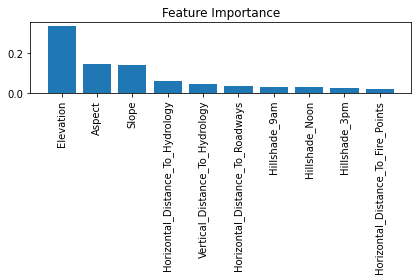

In [128]:
plt.title('Feature Importance')
plt.bar(range(0,10), importances[sorted_indices[0:10]], align='center')
plt.xticks(range(0,10),covtype.feature_names[0:10], rotation=90)
plt.tight_layout()
plt.show()

In [112]:
from sklearn.model_selection import GridSearchCV

param = {'criterion':('gini', 'entropy'),'n_estimators': [10,64,120], 'max_features' : [10,54,120]}
rand = RandomForestClassifier()
tree = GridSearchCV(rand, param,n_jobs=-1)

In [113]:
tree.fit(x, y)

ŷ = tree.predict(xt)
accuracy_score(yt, ŷ)

0.970904365635999

In [130]:
tree.best_estimator_

RandomForestClassifier(criterion='entropy', max_features=54, n_estimators=64)

# Gradient Tree Boosting


XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman.

Gradient boosting is an ensembling technique where several weak learners (regression trees) are combined to yield a powerful single model, in an iterative fashion.

**Tree sizes**

Take j as a parameter in gradient boosting that denotes the tree number terminal nodes. Parameter j is adjustable, depending on the data being handled, and controls the number of times variables interact in a model. When the decision stumps are two, i.e., j=2, interactions between variables in the model are not allowed.

**Regularization**

When training sets are fit too close, they tend to move toward degradation in their ability to generalize a model. Regularization techniques are used to reduce the overfitting effect, eliminating the degradation by ensuring the fitting procedure is constrained.

**Early stopping**

Early stopping support in Gradient Boosting enables us to find the least number of iterations which is sufficient to build a model that generalizes well to unseen data.

**Shrinkage**

Shrinkage is a gradient boosting regularization procedure that helps modify the update rule, which is aided by a parameter known as the learning rate. The use of learning rates below 0.1 produces improvements that are significant in the generalization of a model.

The dramatic improvements can be witnessed in gradient boosting without shrinkage, where the learning rate parameter is equal to 1. The computational time will, however, be raised, which is more expensive during querying and training. This is because when the learning rate is low, the number of iterations required will rise.

**Penalization**

Another gradient boosting regularization method is to penalize the complexity of trees. The complexity of a model can be defined as the number of proportional tree leaves. The optimization of the model can be done by pruning the trees to reduce the model’s complexity, which eliminates any branches that can’t reach the threshold’s loss.




In [16]:
import xgboost as xgb

In [12]:
# since we're building a multiclass classifier we use softmax
# this model will score about as well as the best Random Forest

p = {'objective':'multi:softmax',
     'eta':0.2,
     'max_depth':30,
     'num_class':54,
     'eval_metric':'merror',
     'nthread':'32'}

# XGBoost wants the data serialized into a data structure called Dmatrix
dat = xgb.DMatrix(x, label=y)
datt = xgb.DMatrix(xt, label=yt)
watch = [(dat, 'train'), (datt, 'test')]
score = {}

mxgb = xgb.train(p, dat, 50, watch, evals_result=score)

[0]	train-merror:0.10778	test-merror:0.12069
[1]	train-merror:0.09150	test-merror:0.10730
[2]	train-merror:0.07017	test-merror:0.09255
[3]	train-merror:0.05081	test-merror:0.07988
[4]	train-merror:0.03852	test-merror:0.07131
[5]	train-merror:0.02972	test-merror:0.06542
[6]	train-merror:0.02288	test-merror:0.06065
[7]	train-merror:0.01767	test-merror:0.05718
[8]	train-merror:0.01345	test-merror:0.05395
[9]	train-merror:0.01033	test-merror:0.05112
[10]	train-merror:0.00772	test-merror:0.04879
[11]	train-merror:0.00579	test-merror:0.04705
[12]	train-merror:0.00432	test-merror:0.04536
[13]	train-merror:0.00326	test-merror:0.04386
[14]	train-merror:0.00237	test-merror:0.04213
[15]	train-merror:0.00169	test-merror:0.04115
[16]	train-merror:0.00123	test-merror:0.03981
[17]	train-merror:0.00086	test-merror:0.03900
[18]	train-merror:0.00058	test-merror:0.03812
[19]	train-merror:0.00039	test-merror:0.03747
[20]	train-merror:0.00025	test-merror:0.03686
[21]	train-merror:0.00016	test-merror:0.0360

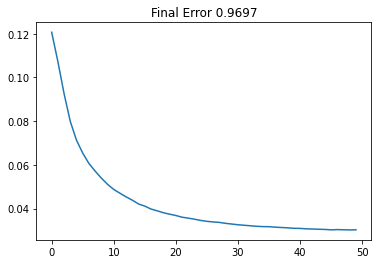

In [13]:
plt.close('all')

epoch = list(range(len(score['test']['merror'])))
ŷ = mxgb.predict(datt)
s = accuracy_score(yt, ŷ)

plt.plot(epoch, score['test']['merror'], label='test')
plt.title("Final Error %0.4f" % s)
plt.show()

In [14]:
cv_results = xgb.cv(dtrain=dat, params=p,
                    nfold=7,
                    num_boost_round=5,
                    metrics="merror",
                    verbose_eval=True,
                    as_pandas=True)

[0]	train-merror:0.11577+0.00165	test-merror:0.12936+0.00234
[1]	train-merror:0.09731+0.00147	test-merror:0.11532+0.00194
[2]	train-merror:0.07492+0.00068	test-merror:0.09895+0.00155
[3]	train-merror:0.05460+0.00032	test-merror:0.08527+0.00171
[4]	train-merror:0.04085+0.00045	test-merror:0.07593+0.00161


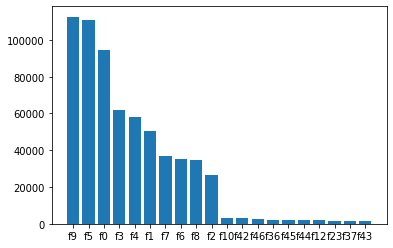

In [38]:
import operator

importance = dict(reversed(sorted(mxgb.get_score().items(), key=operator.itemgetter(1))))

# clear old visualizations
plt.close('all')

# visualize the points
fig, ax = plt.subplots()
plt.bar(list(importance.keys())[0:20], list(importance.values())[0:20])
plt.show()

In [41]:
# we can reduce the dataset by 80% and achieve a similar score

x, xt, y, yt = train_test_split(covtype.data[:,[9,5,0,3,4,1,7,6,8,2]], covtype.target, test_size = 0.20)

In [42]:
p = {'objective':'multi:softmax',
     'eta':0.2,
     'max_depth':30,
     'num_class':9,
     'eval_metric':'merror',
     'nthread':'32'}

# XGBoost wants the data serialized into a data structure called Dmatrix
dat = xgb.DMatrix(x, label=y)
datt = xgb.DMatrix(xt, label=yt)
watch = [(dat, 'train'), (datt, 'test')]
score = {}

mxgb = xgb.train(p, dat, 50, watch, evals_result=score)

[0]	train-merror:0.04798	test-merror:0.09080
[1]	train-merror:0.02670	test-merror:0.06837
[2]	train-merror:0.01724	test-merror:0.06008
[3]	train-merror:0.01217	test-merror:0.05469
[4]	train-merror:0.00863	test-merror:0.05145
[5]	train-merror:0.00643	test-merror:0.04928
[6]	train-merror:0.00488	test-merror:0.04703
[7]	train-merror:0.00360	test-merror:0.04545
[8]	train-merror:0.00272	test-merror:0.04398
[9]	train-merror:0.00202	test-merror:0.04270
[10]	train-merror:0.00148	test-merror:0.04159
[11]	train-merror:0.00108	test-merror:0.04088
[12]	train-merror:0.00080	test-merror:0.04019
[13]	train-merror:0.00059	test-merror:0.03952
[14]	train-merror:0.00044	test-merror:0.03889
[15]	train-merror:0.00032	test-merror:0.03833
[16]	train-merror:0.00024	test-merror:0.03800
[17]	train-merror:0.00019	test-merror:0.03738
[18]	train-merror:0.00013	test-merror:0.03681
[19]	train-merror:0.00011	test-merror:0.03651
[20]	train-merror:0.00009	test-merror:0.03607
[21]	train-merror:0.00007	test-merror:0.0357

In [45]:
ŷ = mxgb.predict(datt)
accuracy_score(yt, ŷ)

0.9681935922480487